In [1]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import yaml

from scaling.models.model_factory import MODELS

In [2]:
def count_params(model):
    return sum([x.numel() for x in model.parameters() if x.requires_grad])

In [3]:
model_sizes = {k: count_params(v()) for k, v in MODELS.items()}

# Loading training summarys

In [4]:
def load_summary(summary: Path) -> dict:
    with summary.open(mode="r") as file:
        return json.load(file)

def load_config(path: Path) -> dict:
    with path.open(mode="r") as file:
        return yaml.safe_load(file)

def get_model_name_from_config(path: Path) -> str:
    config = load_config(path)
    return config["model_name"]["value"]

In [5]:
summarys = []
for run in Path("../wandb").iterdir():
    if not run.name.startswith("run"):
        continue
    config = load_config(run / "files" / "config.yaml")
    summary = load_summary(run / "files" / "wandb-summary.json")    
    
    wandb_stats = summary.pop("_wandb")
    for k, v in wandb_stats.items():
        summary[k] = v

    summary["model_name"] = config["model_name"]["value"]
    summary["loss_fn"] = config["loss_fn"]["value"]
    summary["fold"] = config["fold"]["value"]

    summary["wandb_id"] = run.name.split("-")[-1]

    summarys.append(summary)
df = pd.DataFrame(summarys)
df["model_size"] = df.model_name.map(lambda x: model_sizes[x])

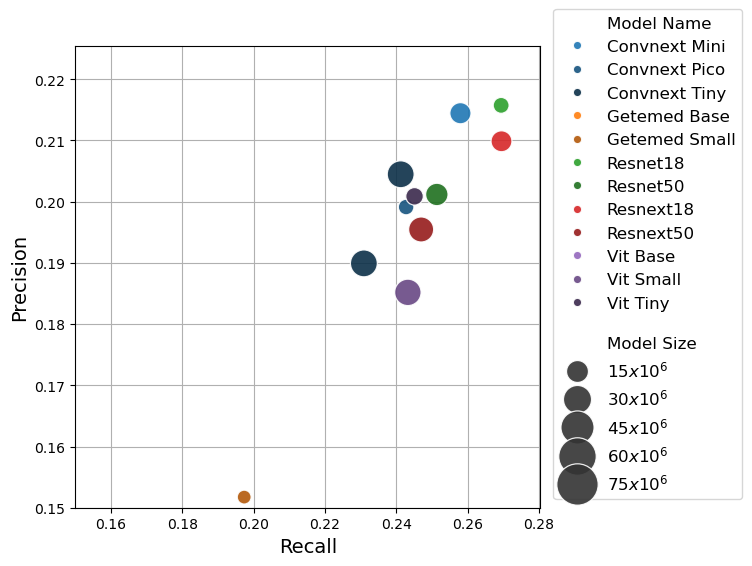

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
import seaborn as sns
import numpy as np

# Define the group sizes
group_sizes = [3, 2, 2, 2, 3]

# Base colormap (e.g., tab20)
base_cmap = plt.get_cmap("tab10")

# Generate slightly different colors for each group
colors = []
color_idx = 0  # Track base color index

for group_size in group_sizes:
    base_color = np.array(to_rgba(base_cmap(color_idx)))  # Base color
    for i in range(group_size):
        # Adjust brightness slightly for pairs
        factor = 1 - 0.3 * (i % group_size)  # Slightly darker shades within the group
        adjusted_color = base_color * factor
        adjusted_color[3] = base_color[3]  # Preserve alpha
        colors.append(adjusted_color)
    color_idx += 1

# Create the custom colormap
custom_cmap = ListedColormap(colors)

sorted_data = df[df.loss_fn == "ASL"].sort_values("model_name")

plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data=sorted_data, 
    x="Recall", 
    y="Precision", 
    hue="model_name", 
    size="model_size",
    sizes=(100, 1000),
    alpha=0.9,
    palette=custom_cmap.colors,
    zorder=2
)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(0.15, xmax)
plt.ylim(0.15, ymax)

# Change legend titles
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    title="", 
    fontsize=12, 
    bbox_to_anchor=(1.01, 0),  # Set the location
    loc="lower left"          # Anchor point of the legend box
)

for i, text in enumerate(legend.get_texts()):
    _text = text.get_text()
    if i < 14:
        new_text = _text.replace("_", " ").title()
        if i == 13:
            new_text = "\n" + new_text
        text.set_text(new_text)   
    else:
        text.set_text(_text[:2] + "$x 10^6$")
    

plt.grid()
plt.show()


# Loading saved models

In [16]:
top_model = {
    "AUPRC": 0.548,
    "AUROC": 0.949,
    "Accuracy": 0.418,
    "F-Measure": 0.521,
    "Challenge Score": 0.696
}

In [17]:
from scaling.models.module import LitModel
from scaling.datasets.physionet import PhysionetDM
from scaling.augmentations import ECGAugmentation
from scaling.metrics import scalar_metrics, PhysionetMetric
from scaling.datasets.physionet import CLASSES, SINUS_RYTHM, WEIGHTS
from tqdm import tqdm

from torchmetrics.wrappers import BootStrapper

In [83]:
class CheckpointLoader:
    def __init__(self, ckpt_path, df):
        self.ckpt_path = Path(ckpt_path)
        self.df = df

    def load(self, **filter_args):
        _id = self.checkpoint_id(**filter_args)
        ckpt = next((self.ckpt_path / _id).rglob("*.ckpt"))
        return LitModel.load_from_checkpoint(ckpt)
    
    def checkpoint_id(self, **filter_args):
        _df = self.df.copy()
        
        # Apply the filtering
        for key, value in filter_args.items():
            if key in _df.columns:
                _df = _df[_df[key] == value]
            else:
                raise KeyError(f"Column '{key}' does not exist in the dataframe.")

        if len(_df) > 1:
            print(f"WARN: Filter more!! I got {len(_df)} samples fitting the criteria {filter_args}.")
            _df = _df.iloc[[0]]

        if len(_df) == 0:
            raise ValueError("Model not Found!")
        sample = _df["wandb_id"].item()
        return sample

In [84]:
def evaluate_model(model, model_name="", quantile=0.5, num_bootstraps=10):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    model = model.eval().to(device)

    # Metrics
    metrics = scalar_metrics()
    physiomet = PhysionetMetric(WEIGHTS, CLASSES, SINUS_RYTHM)
    bootstrap = BootStrapper(physiomet, num_bootstraps=num_bootstraps, quantile=quantile)

    # Dataset
    valid_transform = ECGAugmentation()
    train_transform = ECGAugmentation()
    dm = PhysionetDM("/sc-scratch/sc-scratch-gbm-radiomics/ecg/physionet_challenge/training_pt/metadata_v5.csv", train_transform=train_transform, val_transform=valid_transform, fold=0)
    dm.setup()
    dataloader = dm.val_dataloader()
    dataloader.num_workers = 32
    dataloader.prefetch_factor = 2

    # Evaluate
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(dataloader, total=len(dataloader), desc=model_name)):
            pred = model(x.to(device))
            pred, y = pred.cpu(), y.int().cpu()

            metrics(pred, y)
            bootstrap.update(pred, y)

    # Format output
    result = metrics.compute()
    for k, v in bootstrap.compute().items():
        result[f"PhysioAccuracy_{k}"] = v

    for k, v in result.items():
        result[k] = v.item()

    result["model_name"] = model_name
    
    return result

In [85]:
loader = CheckpointLoader("../PhysioNetScaling", df)

In [86]:
done = [x["model_name"] for x in results]

In [87]:
# results = []
for model_name in list(df.loc[(df.loss_fn == "ASL") & (df.fold == 0), "model_name"]):
    if model_name in done:
        continue
    model = loader.load(model_name=model_name, loss_fn="ASL")

    result = evaluate_model(model, model_name)
    results.append(result)

results = pd.DataFrame(results)

WARN: Filter more!! I got 2 samples fitting the criteria {'model_name': 'convnext_tiny', 'loss_fn': 'ASL'}.


convnext_tiny:   0%|          | 0/828 [00:00<?, ?it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
convnext_tiny:  36%|███▋      | 301/828 [00:20<00:42, 12.30it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
convnext_tiny:  46%|████▌     | 379/828 [00:25<00:20, 21.81it/s]Excep

WARN: Filter more!! I got 2 samples fitting the criteria {'model_name': 'convnext_tiny', 'loss_fn': 'ASL'}.


convnext_tiny:   0%|          | 0/828 [00:00<?, ?it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
convnext_tiny:  36%|███▌      | 299/828 [00:18<00:37, 14.00it/s]/home/jabareen/.conda/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
convnext_mini:   0%|          | 0/828 [00:00<?, ?it/s]/home/jabareen/

In [88]:
results.to_csv("evaluation2.csv")

In [89]:
results = pd.read_csv("evaluation2.csv", index_col=0)

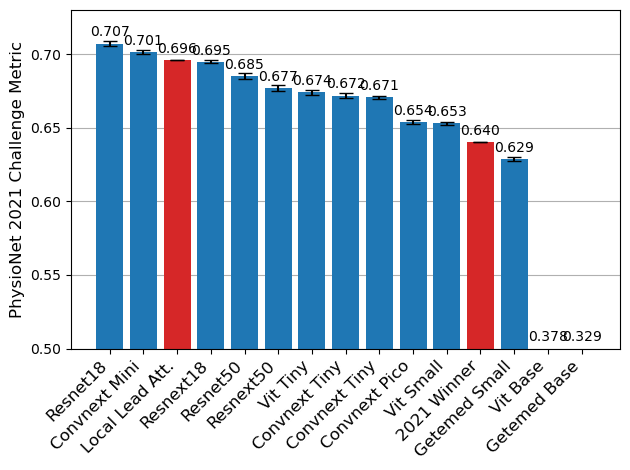

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add new data point
new_model = pd.DataFrame({
    "model_name": ["Local Lead Att.", "2021 Winner"],
    "PhysioAccuracy_mean": [0.696, 0.640],
    "PhysioAccuracy_std": [0.0, 0.0]
})
_results = pd.concat([results, new_model], ignore_index=True)

# Sort by PhysioAccuracy_mean
_results = _results.sort_values(by="PhysioAccuracy_mean", ascending=False).reset_index(drop=True)

# Data for the bar plot
x = np.arange(len(_results))  # Positions for the bars
y = _results["PhysioAccuracy_mean"]  # Mean values
yerr = _results["PhysioAccuracy_std"]  # Error bars

bar_colors = ['tab:blue'] * 13
for make_red in np.unique(np.where(_results.isna())[0]):
    bar_colors[make_red] = "tab:red"

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(x, y, yerr=yerr, capsize=5, zorder=2, color=bar_colors)

# Add labels to each bar
for bar in bars:
    height = bar.get_height()
    y = max([height, 0.5])
    ax.annotate(f'{height:.3f}',  # Format the label
                xy=(bar.get_x() + bar.get_width() * 0.5, y),  # Position
                xytext=(0, 3),  # Offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(_results["model_name"].apply(lambda x: x.replace("_", " ").title()), fontsize=12, rotation=45, ha="right")

ax.set_ylim(0.5, 0.73)

ymax = _results["PhysioAccuracy_mean"].max() + _results["PhysioAccuracy_std"].max()
ax.grid(axis="y")
ax.set_xlabel("")
ax.set_ylabel("PhysioNet 2021 Challenge Metric", fontsize=12)

plt.tight_layout()
plt.savefig("./plots/baseline_performance.png", dpi=280)
plt.show()

In [91]:
results["model_size"] = results.model_name.apply(lambda x: model_sizes[x])

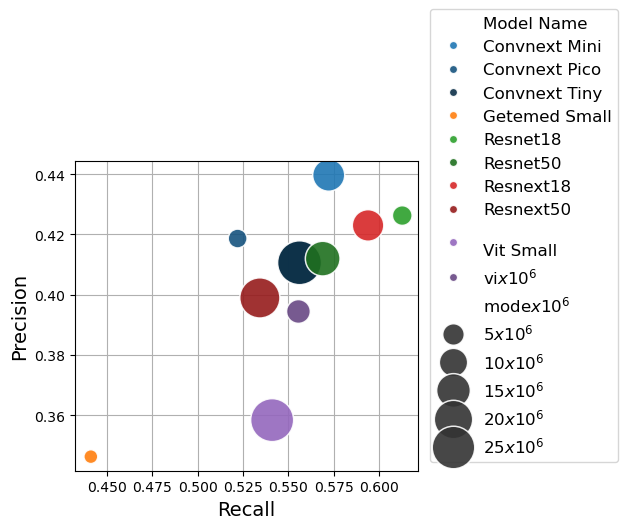

In [92]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
import seaborn as sns
import numpy as np

# Define the group sizes
group_sizes = [3, 1, 2, 2, 2]

# Base colormap (e.g., tab20)
base_cmap = plt.get_cmap("tab10")

# Generate slightly different colors for each group
colors = []
color_idx = 0  # Track base color index

for group_size in group_sizes:
    base_color = np.array(to_rgba(base_cmap(color_idx)))  # Base color
    for i in range(group_size):
        # Adjust brightness slightly for pairs
        factor = 1 - 0.3 * (i % group_size)  # Slightly darker shades within the group
        adjusted_color = base_color * factor
        adjusted_color[3] = base_color[3]  # Preserve alpha
        colors.append(adjusted_color)
    color_idx += 1

# Create the custom colormap
custom_cmap = ListedColormap(colors)

sorted_data = results[~results.model_name.isin(["vit_base", "getemed_base"])].sort_values("model_name")

# plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    data=sorted_data, 
    x="Recall", 
    y="Precision", 
    hue="model_name", 
    size="model_size",
    sizes=(100, 1000),
    alpha=0.9,
    palette=custom_cmap.colors,
    zorder=2
)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# plt.xlim(0.15, xmax)
# plt.ylim(0.15, ymax)

# Change legend titles
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    title="", 
    fontsize=12, 
    bbox_to_anchor=(1.01, 0),  # Set the location
    loc="lower left"          # Anchor point of the legend box
)

for i, text in enumerate(legend.get_texts()):
    _text = text.get_text()
    if i < 10:
        new_text = _text.replace("_", " ").title()
        if i == 9:
            new_text = "\n" + new_text
        text.set_text(new_text)   
    else:
        text.set_text(_text[:-6] + "$x 10^6$")

plt.grid()
plt.tight_layout()
plt.savefig("./plots/baseline_recall_precision.png", dpi=280)
plt.show()

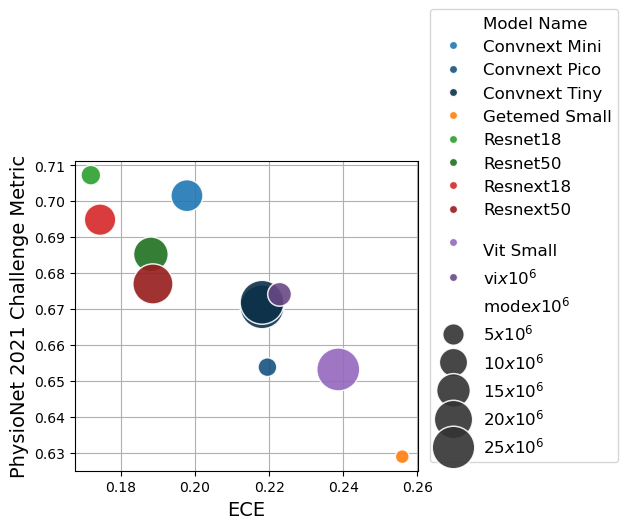

In [93]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
import seaborn as sns
import numpy as np

# Define the group sizes
group_sizes = [3, 1, 2, 2, 2]

# Base colormap (e.g., tab20)
base_cmap = plt.get_cmap("tab10")

# Generate slightly different colors for each group
colors = []
color_idx = 0  # Track base color index

for group_size in group_sizes:
    base_color = np.array(to_rgba(base_cmap(color_idx)))  # Base color
    for i in range(group_size):
        # Adjust brightness slightly for pairs
        factor = 1 - 0.3 * (i % group_size)  # Slightly darker shades within the group
        adjusted_color = base_color * factor
        adjusted_color[3] = base_color[3]  # Preserve alpha
        colors.append(adjusted_color)
    color_idx += 1

# Create the custom colormap
custom_cmap = ListedColormap(colors)

sorted_data = results[~results.model_name.isin(["vit_base", "getemed_base"])].sort_values("model_name")


ax = sns.scatterplot(
    data=sorted_data, 
    x="ECE", 
    y="PhysioAccuracy_mean", 
    hue="model_name", 
    size="model_size",
    sizes=(100, 1000),
    alpha=0.9,
    palette=custom_cmap.colors,
    zorder=2
)

plt.xlabel("ECE", fontsize=14)
plt.ylabel("PhysioNet 2021 Challenge Metric", fontsize=14)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# plt.xlim(0.15, xmax)
# plt.ylim(0.15, ymax)

# Change legend titles
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    title="", 
    fontsize=12, 
    bbox_to_anchor=(1.01, 0),  # Set the location
    loc="lower left"          # Anchor point of the legend box
)

for i, text in enumerate(legend.get_texts()):
    _text = text.get_text()
    if i < 10:
        new_text = _text.replace("_", " ").title()
        if i == 9:
            new_text = "\n" + new_text
        text.set_text(new_text)   
    else:
        text.set_text(_text[:-6] + "$x 10^6$")

plt.grid()
plt.tight_layout()
plt.savefig("./plots/baseline_performance_ece.png", dpi=280)
plt.show()